In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering, DBSCAN
from scipy.spatial.distance import cdist
import math

In [12]:
def show_image(image, title=None):
    """
    Display an image in a Jupyter notebook with an optional title.
    
    Parameters:
        image (numpy.ndarray or PIL.Image): The image to display.
        title (str, optional): The title of the image.
    """
    plt.figure(figsize=(6, 6))

    if image.ndim == 2:  # Grayscale
        plt.imshow(image, cmap='gray')
    elif image.ndim == 3 and image.shape[2] == 3:  # RGB
        plt.imshow(image)
    else:
        raise ValueError("Image must be either RGB (H, W, 3) or grayscale (H, W).")

    if title:
        plt.title(title, fontsize=14)
    plt.axis('off')
    plt.show()

In [13]:
def preprocess_image(image_path):
    """Load and preprocess the input image
    Reads the image from file
    Converts from BGR (OpenCV format) to RGB (matplotlib format)
    Converts to grayscale for edge detection
    Returns: Original image, RGB version, and grayscale version
    """
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img, img_rgb, gray

def detect_edges(gray_img, threshold1=50, threshold2=200):
    """Apply Canny edge detection
    Applies Gaussian blur to reduce noise
    Uses Canny edge detector with two thresholds (50 and 150)
    Returns: Binary image where edges are white pixels"""
    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(gray_img, (5, 5), 0)
    edges = cv2.Canny(blurred, threshold1, threshold2)
    
    return edges

def dilate_image(image, iterations=1):
    """Apply dilation to the image"""
    return cv2.dilate(image, None, iterations=iterations) 

def detect_lines(edges, hough_threshold=50, min_line_length=50, max_line_gap=20):
    """Detect lines using Hough Transform
    Uses Probabilistic Hough Transform (HoughLinesP)
    Looks for lines that are at least min_line_length pixels long
    Allows gaps of up to max_line_gap pixels between line segments
    Returns: List of detected line segments
    """
    lines = cv2.HoughLinesP(edges, 1, np.pi/180, threshold=hough_threshold, minLineLength=min_line_length, maxLineGap=max_line_gap)
    return lines

def calculate_line_angle(line):
    """Calculate the angle of a line in degrees
    Purpose: Calculate the orientation of a line
    Takes start and end points of a line
    Computes angle using arctangent function
    Normalizes angle to 0-180 degrees range
    Returns: Angle in degrees"""
    x1, y1, x2, y2 = line[0]
    angle = math.degrees(math.atan2(y2 - y1, x2 - x1))
    return angle % 180  



In [14]:
def show_lines(image, lines, title="Detected Lines", color=(255, 0, 0), thickness=2):
    """
    Display an image with detected lines overlaid.
    Parameters:
        image (np.ndarray): The base image (RGB or grayscale).
        lines (list): Lines returned by HoughLinesP or similar (each line is [[x1, y1, x2, y2]]).
        title (str): Optional title.
        color (tuple): Line color in RGB format.
        thickness (int): Line thickness in pixels.
    """
    # Make sure we have an RGB image for plotting
    if image.ndim == 2:  # grayscale → convert to RGB for color lines
        img_vis = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    else:
        img_vis = image.copy()

    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            cv2.line(img_vis, (x1, y1), (x2, y2), color, thickness)

    plt.figure(figsize=(6, 6))
    plt.imshow(img_vis)
    plt.title(title)
    plt.axis('off')
    plt.show()

In [15]:
def cluster_lines(lines):
    """Cluster lines into horizontal and vertical groups using agglomerative clustering
    Separate lines into horizontal and vertical groups
    Calculates angles for all lines
    Uses Agglomerative Clustering to group similar angles
    Determines which cluster is horizontal vs vertical
    Returns: Two lists - horizontal lines and vertical lines
    """
    if lines is None:
        return [], []
    
    angles = []
    for line in lines:
        angle = calculate_line_angle(line)
        angles.append(angle)
    
    angles = np.array(angles).reshape(-1, 1)
    
    # Use agglomerative clustering to separate horizontal and vertical lines
    clustering = AgglomerativeClustering(n_clusters=2, metric='manhattan', linkage='complete')
    cluster_labels = clustering.fit_predict(angles)
    
    horizontal_lines = []
    vertical_lines = []
    
    for i, line in enumerate(lines):
        if cluster_labels[i] == 0:
            horizontal_lines.append(line)
        else:
            vertical_lines.append(line)
    
    # Determine which cluster is horizontal and which is vertical
    if len(horizontal_lines) > 0 and len(vertical_lines) > 0:
        horizontal_angles = [calculate_line_angle(line) for line in horizontal_lines]
        vertical_angles = [calculate_line_angle(line) for line in vertical_lines]
        
        avg_horizontal = np.mean(horizontal_angles)
        avg_vertical = np.mean(vertical_angles)
        
        # Horizontal lines should be around 0 or 180 degrees, vertical around 90
        if abs(avg_vertical - 90) < abs(avg_horizontal - 90):
            # Current assignment is correct
            pass
        else:
            # Swap the clusters
            horizontal_lines, vertical_lines = vertical_lines, horizontal_lines
    
    return horizontal_lines, vertical_lines

In [16]:
def find_line_intersections(horizontal_lines, vertical_lines):
    """Find intersection points between horizontal and vertical lines"""
    intersections = []
    
    for h_line in horizontal_lines:
        for v_line in vertical_lines:
            x1, y1, x2, y2 = h_line[0]
            x3, y3, x4, y4 = v_line[0]
            
            # Calculate intersection point
            denom = (x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4)
            if abs(denom) > 1e-10:  # Avoid division by zero
                px = ((x1*y2 - y1*x2)*(x3-x4) - (x1-x2)*(x3*y4 - y3*x4)) / denom
                py = ((x1*y2 - y1*x2)*(y3-y4) - (y1-y2)*(x3*y4 - y3*x4)) / denom
                
                # Check if intersection is within reasonable bounds
                if (0 <= px <= 2000 and 0 <= py <= 2000):  # Adjust bounds as needed
                    intersections.append((px, py))
    
    return intersections

In [17]:
def compute_homography_ransac(intersections, inlier_threshold=0.1):
    """Compute homography matrix using RANSAC-based approach"""
    if len(intersections) < 4:
        return None, []
    
    intersections = np.array(intersections)
    best_inliers = []
    best_H = None
    
    # Try different scale factors as described in the paper
    for sx in range(1, 9):
        for sy in range(1, 9):
            # Randomly sample 4 points that form a rectangle
            if len(intersections) < 4:
                continue
                
            # Simple implementation: use the first 4 points
            # In a full implementation, you'd use random sampling
            if len(intersections) >= 4:
                src_pts = intersections[:4].astype(np.float32)
                
                # Create destination points based on scale factors
                dst_pts = np.array([
                    [0, 0],
                    [sx, 0],
                    [sx, sy],
                    [0, sy]
                ], dtype=np.float32)
                
                # Compute homography
                H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
                
                if H is not None:
                    # Project all points and count inliers
                    projected = cv2.perspectiveTransform(
                        intersections.reshape(-1, 1, 2).astype(np.float32), H)
                    
                    inliers = []
                    for i, (orig, proj) in enumerate(zip(intersections, projected)):
                        x, y = proj[0]
                        rounded_x, rounded_y = round(x), round(y)
                        distance = np.sqrt((x - rounded_x)**2 + (y - rounded_y)**2)
                        
                        if distance < inlier_threshold:
                            inliers.append(i)
                    
                    if len(inliers) > len(best_inliers):
                        best_inliers = inliers
                        best_H = H
    
    return best_H, best_inliers

In [18]:
def recover_missing_lines(warped_img, x_min, x_max, y_min, y_max):
    """Recover missing chessboard lines using gradient analysis"""
    # Convert to grayscale if needed
    if len(warped_img.shape) == 3:
        warped_gray = cv2.cvtColor(warped_img, cv2.COLOR_RGB2GRAY)
    else:
        warped_gray = warped_img
    
    # Compute horizontal gradient (for vertical lines)
    sobel_x = cv2.Sobel(warped_gray, cv2.CV_64F, 1, 0, ksize=3)
    sobel_x_abs = np.absolute(sobel_x)
    sobel_x_uint8 = np.uint8(sobel_x_abs / sobel_x_abs.max() * 255)
    
    # Apply Canny on the gradient image
    edges_x = cv2.Canny(sobel_x_uint8, 50, 150)
    
    # Sum intensities at potential new vertical line positions
    left_intensity = np.sum(edges_x[:, max(0, x_min-5):x_min+5])
    right_intensity = np.sum(edges_x[:, max(0, x_max-5):x_max+5])
    
    # Update x_min and x_max based on gradient analysis
    if left_intensity > right_intensity and x_min > 0:
        x_min -= 1
    else:
        x_max += 1
    
    # Similar process for horizontal lines (using vertical gradient)
    sobel_y = cv2.Sobel(warped_gray, cv2.CV_64F, 0, 1, ksize=3)
    sobel_y_abs = np.absolute(sobel_y)
    sobel_y_uint8 = np.uint8(sobel_y_abs / sobel_y_abs.max() * 255)
    
    edges_y = cv2.Canny(sobel_y_uint8, 50, 150)
    
    top_intensity = np.sum(edges_y[max(0, y_min-5):y_min+5, :])
    bottom_intensity = np.sum(edges_y[max(0, y_max-5):y_max+5, :])
    
    if top_intensity > bottom_intensity and y_min > 0:
        y_min -= 1
    else:
        y_max += 1
    
    return x_min, x_max, y_min, y_max


In [19]:
def visualize_results(original_img, edges, lines_img, intersections, warped_img):
    """Visualize the intermediate and final results"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Original image
    axes[0, 0].imshow(original_img)
    axes[0, 0].set_title('Original Image')
    axes[0, 0].axis('off')
    
    # Edge detection
    axes[0, 1].imshow(edges, cmap='gray')
    axes[0, 1].set_title('Canny Edge Detection')
    axes[0, 1].axis('off')
    
    # Detected lines and intersections
    axes[1, 0].imshow(lines_img)
    axes[1, 0].set_title('Detected Lines & Intersections')
    axes[1, 0].axis('off')
    
    # Warped image
    if warped_img is not None:
        axes[1, 1].imshow(warped_img)
        axes[1, 1].set_title('Warped Chessboard')
    else:
        axes[1, 1].text(0.5, 0.5, 'Warping failed', ha='center', va='center', 
                        transform=axes[1, 1].transAxes, fontsize=12)
        axes[1, 1].set_title('Warped Chessboard')
    axes[1, 1].axis('off')
    
    plt.tight_layout()
    plt.show()

def main_board_localization(image_path):
    """Main function for chess board localization"""
    print("Step 1: Loading and preprocessing image...")
    img, img_rgb, gray = preprocess_image(image_path)
    
    print("Step 2: Edge detection...")
    edges = detect_edges(gray)
    
    print("Step 3: Line detection...")
    lines = detect_lines(edges)
    
    if lines is None:
        print("No lines detected! Try adjusting parameters.")
        return None, None, None
    
    print(f"Detected {len(lines)} lines")
    
    print("Step 4: Clustering lines into horizontal and vertical...")
    horizontal_lines, vertical_lines = cluster_lines(lines)
    print(f"Horizontal lines: {len(horizontal_lines)}, Vertical lines: {len(vertical_lines)}")
    
    # Create visualization of detected lines
    lines_img = img_rgb.copy()
    for line in horizontal_lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(lines_img, (x1, y1), (x2, y2), (255, 0, 0), 2)
    for line in vertical_lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(lines_img, (x1, y1), (x2, y2), (0, 255, 0), 2)
    
    print("Step 5: Finding line intersections...")
    intersections = find_line_intersections(horizontal_lines, vertical_lines)
    print(f"Found {len(intersections)} intersections")
    
    # Mark intersections on the image
    for px, py in intersections:
        cv2.circle(lines_img, (int(px), int(py)), 5, (0, 0, 255), -1)
    
    print("Step 6: Computing homography with RANSAC...")
    H, inliers = compute_homography_ransac(intersections)
    
    warped_img = None
    if H is not None:
        print("Homography matrix computed successfully!")
        print(f"Found {len(inliers)} inlier points")
        
        # Warp the image using the homography
        height, width = img_rgb.shape[:2]
        warped_img = cv2.warpPerspective(img_rgb, H, (width, height))
        
        print("Step 7: Recovering missing lines if needed...")
        # This is a simplified version - in practice you'd analyze the warped image
        # to find the exact chessboard boundaries
        
    else:
        print("Failed to compute homography matrix")
    
    print("Step 8: Visualizing results...")
    visualize_results(img_rgb, edges, lines_img, intersections, warped_img)
    
    return H, warped_img, intersections

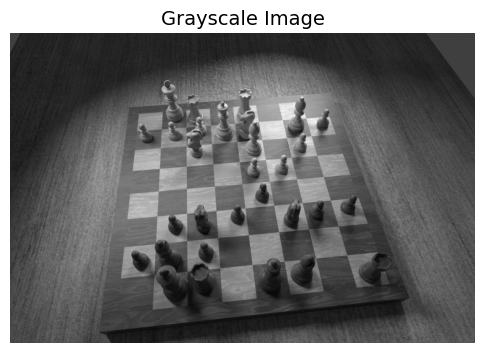

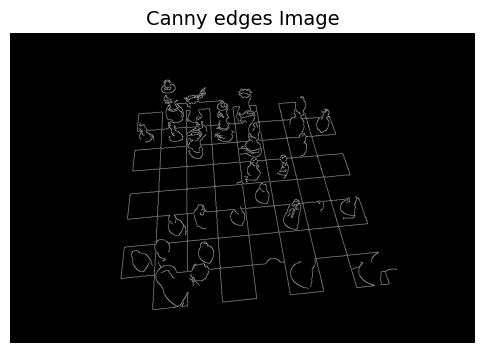

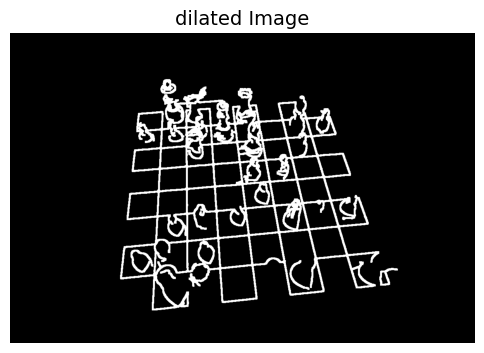

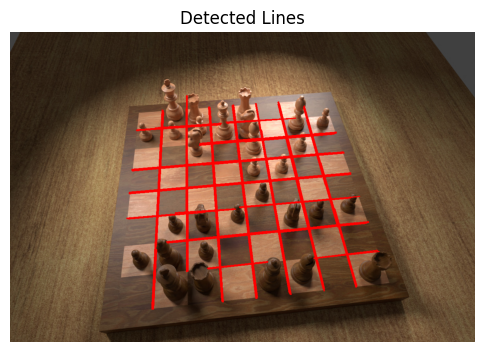

Step 1: Loading and preprocessing image...
Step 2: Edge detection...
Step 3: Line detection...
Detected 63 lines
Step 4: Clustering lines into horizontal and vertical...
Horizontal lines: 32, Vertical lines: 31
Step 5: Finding line intersections...
Found 992 intersections
Step 6: Computing homography with RANSAC...
Homography matrix computed successfully!
Found 31 inlier points
Step 7: Recovering missing lines if needed...
Step 8: Visualizing results...


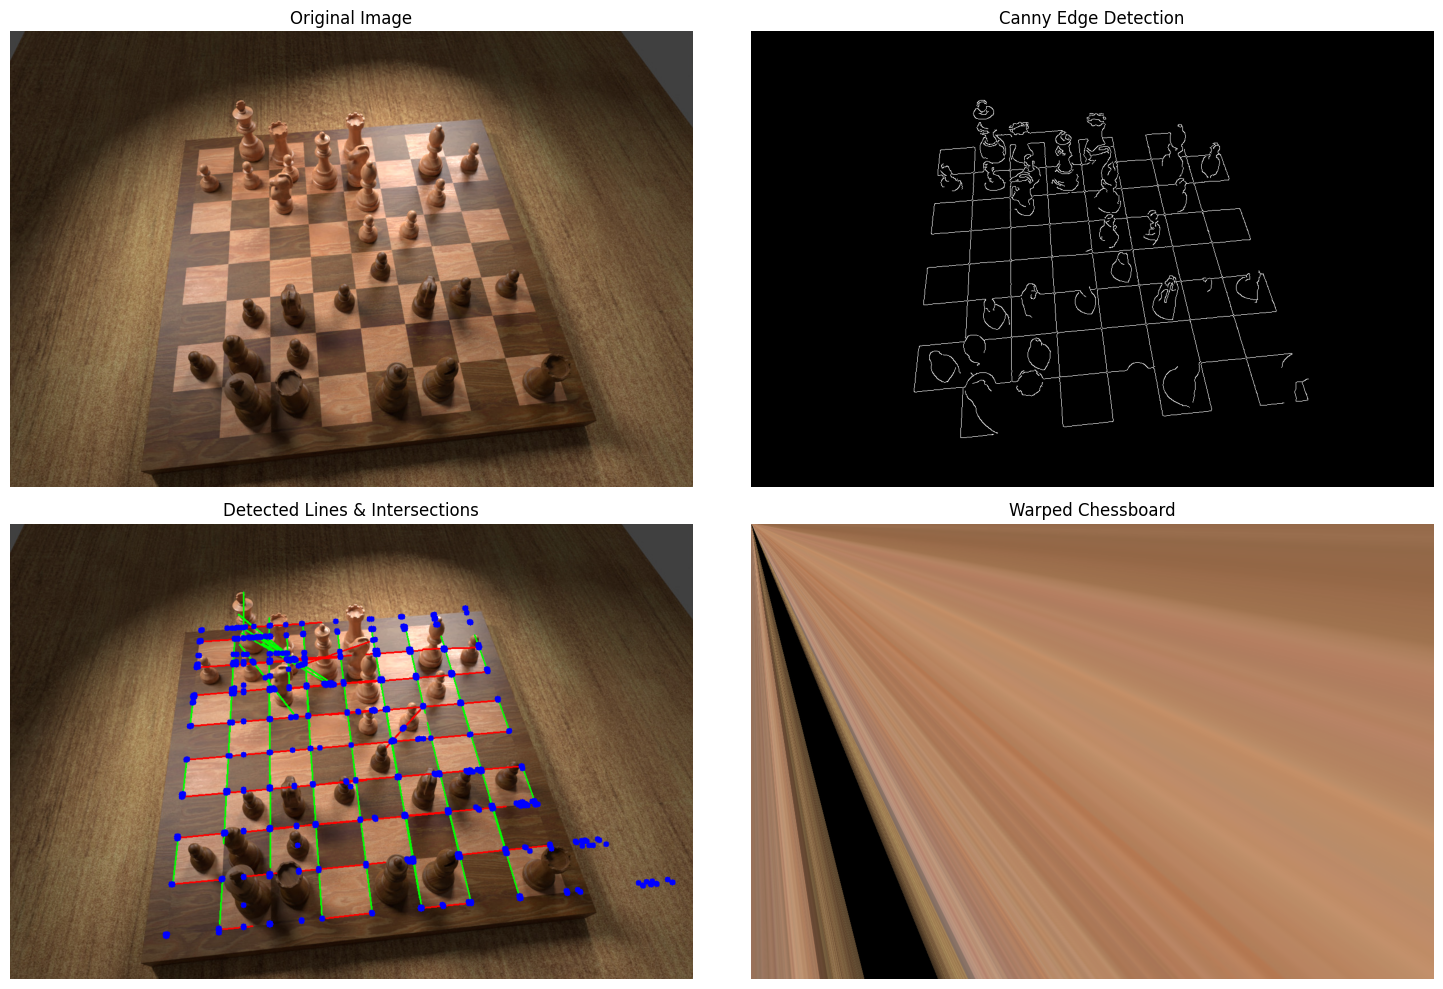


Homography Matrix:
[[ 2.05396719e-05  2.32920000e-04 -1.03029095e-01]
 [ 3.76082939e-05  4.26478461e-04 -1.88647125e-01]
 [-1.99358090e-04 -2.26072040e-03  1.00000000e+00]]

Chessboard localization completed successfully!
Found 992 intersection points


In [21]:
image_path = "chess_board.jpeg" 
    
try:
    img, img_rgb, gray = preprocess_image(image_path)
    show_image(gray, title="Grayscale Image")
    edges = detect_edges(gray,threshold1=10, threshold2=200)
    show_image(edges, title="Canny edges Image")
    edges = dilate_image(edges, iterations=2)
    show_image(edges, title="dilated Image")
    lines = detect_lines(edges, hough_threshold=50, min_line_length=150, max_line_gap=10)
    show_lines(img_rgb, lines, title="Detected Lines")
    #otsu



    H, warped_img, intersections = main_board_localization(image_path)
    if H is not None:
        print("\nHomography Matrix:")
        print(H)
        print(f"\nChessboard localization completed successfully!")
        print(f"Found {len(intersections)} intersection points")
    else:
        print("\nChessboard localization failed. Try adjusting parameters or using a different image.")
            
except Exception as e:
    print(f"Error: {e}")
    print("Make sure the image path is correct and the image contains a clear chessboard.")